In [1]:
import numpy as np
import cv2
import misc
from RL_networks import Stand_alone_net
import pickle

### Naive Random Walk, judt push the images to the networks and see if they can learn to extract information fro m a random combination of images.
In this implimintation we have the Syclop run a random walk on the image, we will see if a basic CNN or RNN network can work with a changing path over the images. 
<br> For each image a new, random, path will be initialized.
<br> This does not work at all, the networks run poorly compared to the case when the same random path is used for all images. 
<br> 

In [2]:
import importlib
importlib.reload(misc)

<module 'misc' from '/home/labs/ahissarlab/orra/imagewalker/misc.py'>

In [3]:

from __future__ import division, print_function, absolute_import

# PyTorch libraries and modules
import torchvision
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.autograd import Variable
from torch.nn import Linear, ReLU, CrossEntropyLoss, Sequential, Conv2d, MaxPool2d, Module, Softmax, BatchNorm2d, Dropout
from torch.optim import Adam, SGD
import torch.nn as nn
from mnist import MNIST

mnist = MNIST('/home/labs/ahissarlab/orra/datasets/mnist')
images, labels = mnist.load_training()

# Training Parameters
learning_rate = 0.001
num_steps = 1000
batch_size = 128

validation_index=-5000

# Network Parameters
size=None
padding_size=(128,128)
# num_input = padding_size[0]*padding_size[1] # MNIST data input (img shape: 28*28)
num_classes = None 
# dropout = 0.25 # Dropout, probability to drop a unit

import matplotlib.pyplot as plt
%matplotlib notebook
import SYCLOP_env as syc



In [4]:
#Define function for low resolution lens on syclop
def bad_res101(img,res):
    sh=np.shape(img)
    dwnsmp=cv2.resize(img,res, interpolation = cv2.INTER_CUBIC)
    upsmp = cv2.resize(dwnsmp,sh, interpolation = cv2.INTER_CUBIC)
    return upsmp

<IPython.core.display.Javascript object>


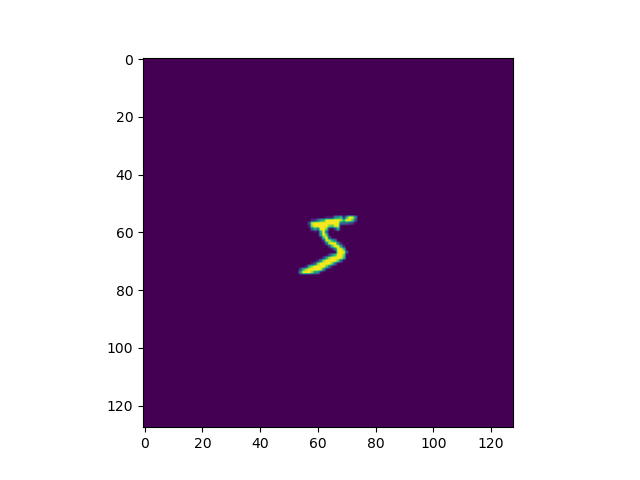

In [5]:
plt.figure()
plt.imshow(misc.build_mnist_padded(1./256*np.reshape(images[0],[1,28,28])))

In [48]:
img=misc.build_mnist_padded(1./256*np.reshape(images[45],[1,28,28]))

In [49]:
scene = syc.Scene(image_matrix=img)
sensor = syc.Sensor(winx=56,winy=56,centralwinx=28,centralwiny=28)
agent = syc.Agent(max_q = [scene.maxx-sensor.hp.winx,scene.maxy-sensor.hp.winy])

In [41]:
starting_point = np.array([agent.max_q[0]//2,agent.max_q[1]//2])
steps  = []
for j in range(5):
    steps.append(starting_point*1)
    starting_point += np.random.randint(-5,5,2) 

q_sequence = np.array(steps).astype(int)
q_sequence

array([[36, 36],
       [33, 37],
       [34, 39],
       [35, 39],
       [36, 40]])

In [50]:
sensor.hp.resolution_fun = lambda x: bad_res101(x,(28,28))
imim=[]
dimim=[]
agent.set_manual_trajectory(manual_q_sequence=q_sequence)
for t in range(10):
    agent.manual_act()
    sensor.update(scene, agent)
    imim.append(sensor.central_frame_view)
    dimim.append(sensor.central_dvs_view)
    

<IPython.core.display.Javascript object>


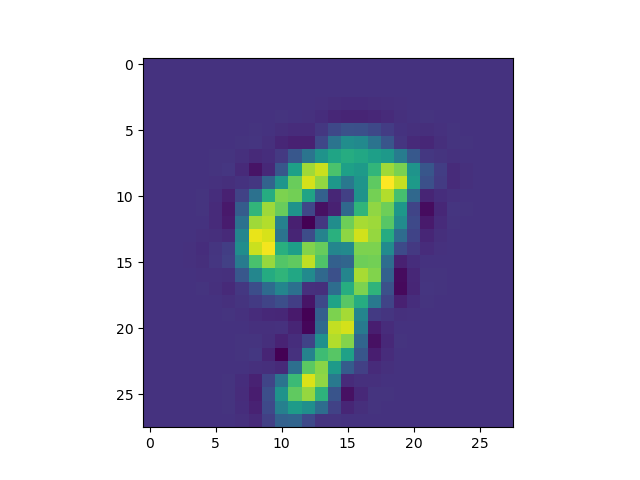

<IPython.core.display.Javascript object>


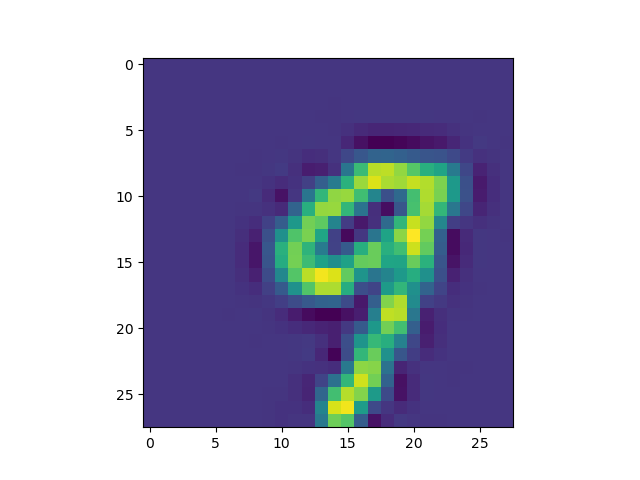

<IPython.core.display.Javascript object>


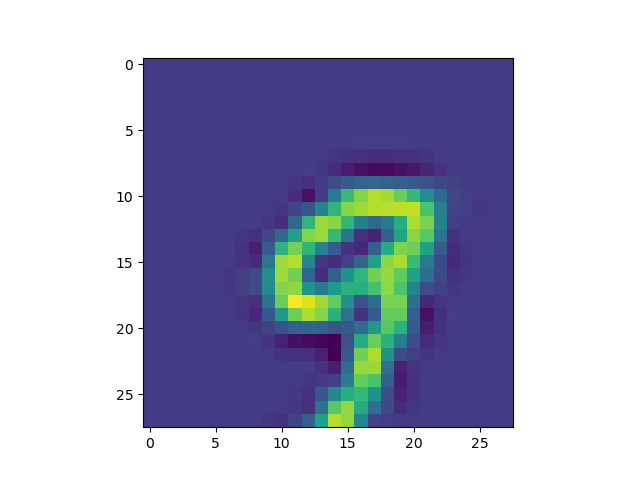

<IPython.core.display.Javascript object>


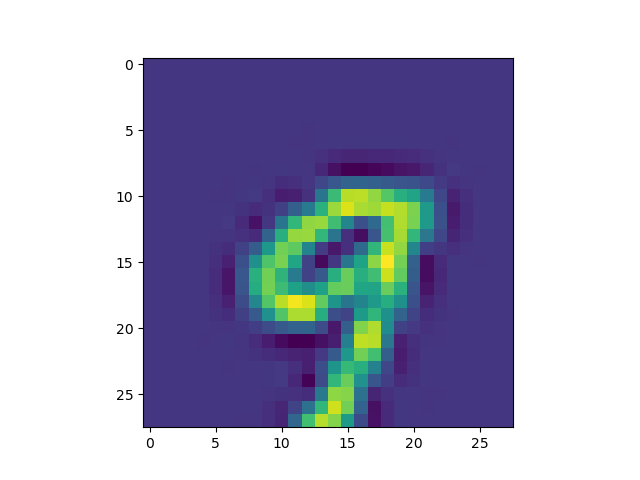

<IPython.core.display.Javascript object>


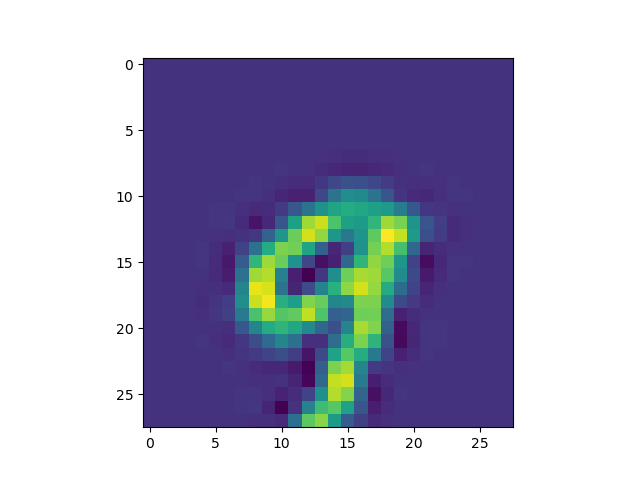

In [51]:
for i in range(5):
    plt.figure()
    plt.imshow(imim[i])

### Create a Dataset from the Syclops visual inputs
We are starting with a simple time series where the syclop starts from the same starting point, at the middle of the img on the x axis and the middle - 10 pixles on the y axis - (middle_point, middle_point - 10)
<br> Each time step the syclop will move one pixle up on the y axis, to a final point at (middle_point, middle_point + 10) and make a circular movement in the x direction.
<br> 

In [5]:
def create_dataset(images, labels, res, sample = 5, mixed_state = True, dvs = False):
    '''
    Creates a torch dataloader object of syclop outputs 
    from a list of images and labels.
    
    Parameters
    ----------
    images : List object holding the images to proces
    labels : List object holding the labels
    res : resolution dawnsampling factor - to be used in cv.resize(orig_img, res)
    sample: the number of samples to have in syclop
    mixed_state : if False, use the same trajectory on every image.

    Returns
    -------
    train_dataloader, test_dataloader - torch DataLoader class objects

    '''
    count = 0
    ts_images = []
    dvs_images = []
    count = 0
    #create subplot to hold examples from the dataset
    fig, ax = plt.subplots(2,5)
    i = 0 #indexises for the subplot for image and for syclop vision
    for img in images:
        orig_img = np.reshape(img,[28,28])
        #Set the padded image
        img=misc.build_mnist_padded(1./256*np.reshape(img,[1,28,28]))
        
        if count < 5:
            ax[0,i].imshow(orig_img) 
            plt.title(labels[count])
        #Set the sensor and the agent
        scene = syc.Scene(image_matrix=img)
        sensor = syc.Sensor(winx=56,winy=56,centralwinx=28,centralwiny=28)
        agent = syc.Agent(max_q = [scene.maxx-sensor.hp.winx,scene.maxy-sensor.hp.winy])
        #Setting the coordinates to visit
        starting_point = np.array([agent.max_q[0]//2,agent.max_q[1]//2])
        
        steps  = []
        for j in range(5):
            steps.append(starting_point*1)
            starting_point += np.random.randint(-5,5,2) 
        
        if mixed_state:
            q_sequence = np.array(steps).astype(int)
        else:
            if count == 0:
                q_sequence = np.array(steps).astype(int)
        #Setting the resolution function - starting with the regular resolution
        sensor.hp.resolution_fun = lambda x: bad_res101(x,(res,res))
        #Create empty lists to store the syclops outputs
        imim=[]
        dimim=[]
        agent.set_manual_trajectory(manual_q_sequence=q_sequence)
        #Run Syclop for 20 time steps
        for t in range(5):
            agent.manual_act()
            sensor.update(scene, agent)
            imim.append(sensor.central_frame_view)
            dimim.append(sensor.central_dvs_view)
        #Create a unified matrix from the list
        if count < 5:
            ax[1,i].imshow(imim[0]) 
            plt.title(labels[count])
            i+=1
            

        imim = np.array(imim)
        dimim = np.array(dimim)
        #Add current proccessed image to lists
        ts_images.append(imim)
        dvs_images.append(dimim)
        count += 1
        


    ts_train = ts_images[:55_000]
    train_labels = labels[:55_000]
    ts_val = ts_images[55_000:]
    val_labels = labels[55_000:]

    dvs_train = dvs_images[:55_000]
    dvs_val = dvs_images[55_000:]
    
    class mnist_dataset(Dataset):
        def __init__(self, data, labels, transform = None):

            self.data = data
            self.labels = labels

            self.transform = transform
        def __len__(self):
            return len(self.data)

        def __getitem__(self, idx):
            '''
            args idx (int) :  index

            returns: tuple(data, label)
            '''
            data = self.data[idx]
            label = self.labels[idx]

            if self.transform:
                data = self.transform(data)
                return data, label
            else:
                return data, label

        def dataset(self):
            return self.data
        def labels(self):
            return self.labels


    if dvs:
        train_dataset = mnist_dataset(dvs_train, train_labels)
        test_dataset = mnist_dataset(dvs_val, val_labels)
    else:
        train_dataset = mnist_dataset(ts_train, train_labels)
        test_dataset = mnist_dataset(ts_val, val_labels)
    batch = 64
    train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size = batch, shuffle = True)
    test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size = batch, shuffle = True)

    
    return train_dataloader, test_dataloader

In [6]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(5,16,3,stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(16,32,3, stride=1, padding=2)
        self.bn2 = nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(32,16,3,stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(16)
        
        self.pool = nn.MaxPool2d(2)
        
        #After the layers and pooling the first two we should get 
        # 16,3,3
        #Flatting it we get:
        # 144
        
        self.fc1 = nn.Linear(8*8*16,64)
        self.fc2 = nn.Linear(64,10)
        
        self.relu = nn.ReLU()
        
    def forward(self, img):
        
        img = self.pool(self.relu(self.bn1(self.conv1(img.double()))))
        img = self.pool(self.relu(self.bn2(self.conv2(img))))
        img = self.relu(self.bn3(self.conv3(img)))        
        #print(img.shape)
        img = img.view(img.shape[0],8*8*16)
        img = self.relu(self.fc1(img))
        img = self.fc2(img)
        
        return img

In [7]:
class CNN_one_layer(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1,16,3,stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(16,32,3, stride=1, padding=2)
        self.bn2 = nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(32,16,3,stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(16)
        
        self.pool = nn.MaxPool2d(2)
        
        #After the layers and pooling the first two we should get 
        # 16,3,3
        #Flatting it we get:
        # 144
        
        self.fc1 = nn.Linear(8*8*16,64)
        self.fc2 = nn.Linear(64,10)
        
        self.relu = nn.ReLU()
        
    def forward(self, img):
        img = img[:,0,:,:]
        img = img.unsqueeze(1)
        img = self.pool(self.relu(self.bn1(self.conv1(img.double()))))
        img = self.pool(self.relu(self.bn2(self.conv2(img))))
        img = self.relu(self.bn3(self.conv3(img)))        
        #print(img.shape)
        img = img.view(img.shape[0],8*8*16)
        img = self.relu(self.fc1(img))
        img = self.fc2(img)
        
        return img

In [8]:
def train(train_dataloader, test_dataloader, net, epochs = 10):

    lr = 3e-3
    #net = CNN().double()
    optimizer = Adam(net.parameters(), lr = lr)
    loss_func = nn.CrossEntropyLoss()
    if torch.cuda.is_available():
        net = net.cuda()
    
    train_loss = []
    test_loss = []
    test_accur = []
    for epoch in range(epochs):

        batch_loss = []
        for batch_idx, (data,targets) in enumerate(train_dataloader):
            if net.__class__.__name__ == 'RNN_Net':
                data = data.unsqueeze(2)
            if torch.cuda.is_available():
                data = data.to('cuda', non_blocking=True)
                targets = targets.to('cuda', non_blocking = True)
            #print(batch_idx, data.shape, targets.shape)

            optimizer.zero_grad()
            output = net(data.double())
            loss = loss_func(output, targets)
            loss.backward()
            optimizer.step()
            batch_loss.append(loss.item())


        train_loss.append(np.mean(batch_loss))

        if epoch%1 == 0:
            correct = 0
            test_batch_loss = []
            test_accuracy = []
            for batch_idx, (test_data,test_targets) in enumerate(test_dataloader):
                if net.__class__.__name__ == 'RNN_Net':
                    test_data = test_data.unsqueeze(2)
                if torch.cuda.is_available():
                    test_data = test_data.to('cuda', non_blocking=True)
                    test_targets = test_targets.to('cuda', non_blocking = True)
                #print(batch_idx, data.shape, targets.shape)

                test_output = net(test_data)
                loss = loss_func(test_output, test_targets)
                test_batch_loss.append(loss.item())
                test_pred = test_output.data.max(1, keepdim = True)[1]
                correct = test_pred.eq(test_targets.data.view_as(test_pred)).sum()
                test_accuracy.append(100.*correct.to('cpu')/len(test_targets))

            print('Net',net.__class__.__name__,'Epoch : ',epoch+1, '\t', 'loss :', loss.to('cpu').item(), 'accuracy :',np.mean(test_accuracy) )
            test_loss.append(np.mean(test_batch_loss))
            test_accur.append(np.mean(test_accuracy))
    
    return train_loss, test_loss, test_accur

In [9]:
class RNN_Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1,16,3,stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(16,32,3, stride=1, padding=2)
        self.bn2 = nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(32,16,3,stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(16)
        
        self.pool = nn.MaxPool2d(2)
        
        #After the layers and pooling the first two we should get 
        # 16,3,3
        #Flatting it we get:
        # 144
        self.gru = nn.GRU(8*8*16,100)
        self.fc1 = nn.Linear(100,10)
        #self.fc2 = nn.Linear(6,10)
        
        self.relu = nn.ReLU()
        
    def forward(self, data):
        hn = torch.zeros([1,data.shape[0],100]).double()
        if torch.cuda.is_available():
            hn = hn.to('cuda')
        #print(data.shape)
        for i in range(data.shape[1]):
            img = data[:,i,:,:,:]
            #print(img.shape)
            #plt.figure()
            #plt.imshow(img[0][0])
            img = self.pool(self.relu(self.bn1(self.conv1(img.double()))))
            img = self.pool(self.relu(self.bn2(self.conv2(img))))
            img = self.relu(self.bn3(self.conv3(img)))        
            img = img.view(img.shape[0],8*8*16)
            out, hn = self.gru(img.unsqueeze(0),hn)
            #print(out.shape)
        output = self.fc1(out[0, :, :])
        
        
        return output

In [10]:
class RNN_Net2(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1,4,3,stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(16,32,3, stride=1, padding=2)
        self.bn2 = nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(32,16,3,stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(16)
        
        self.pool = nn.MaxPool2d(2)
        
        #After the layers and pooling the first two we should get 
        # 16,3,3
        #Flatting it we get:
        # 144
        self.gru = nn.GRU(8*8*16,100, batch_first=True)
        self.fc1 = nn.Linear(100,10)
        #self.fc2 = nn.Linear(6,10)
        
        self.relu = nn.ReLU()
        
    def forward(self, data):
        batch_size, timesteps, C, H, W = data.size()
        img = datax.view(batch_size * timesteps, C, H, W)
        img = self.pool(self.relu(self.bn1(self.conv1(img.double()))))
        img = self.pool(self.relu(self.bn2(self.conv2(img))))
        img = self.relu(self.bn3(self.conv3(img)))        
        print(img.shape)
        img = img.view(img.shape[0],img.shape[1],8*8*16)
        out, hn = self.gru(img)
        output = self.fc1(hn.squeeze(0))
        
        
        return output

### Random Walk: Drew a new random walk for each image

<IPython.core.display.Javascript object>


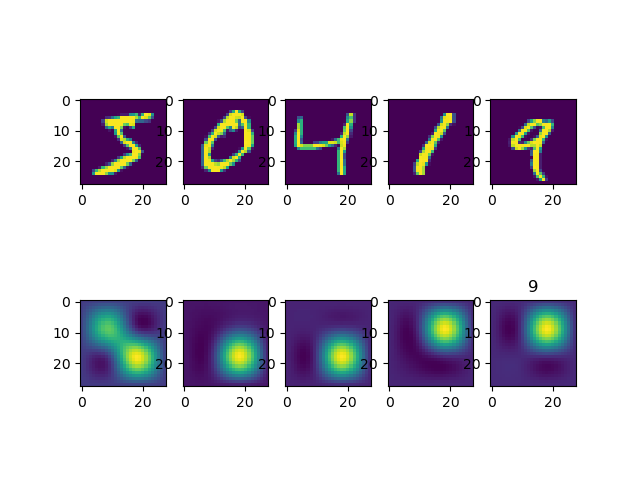

In [11]:
#Load the training data
train_dataloader, test_dataloader = create_dataset(images, labels,res = 6)

In [12]:
#Run the CNN over one image only
train_loss, test_loss, test_accur =  train(train_dataloader, test_dataloader,net = CNN_one_layer().double(), epochs = 10)

Net CNN_one_layer Epoch :  1 	 loss : 1.2650540598834448 accuracy : 45.33228
Net CNN_one_layer Epoch :  2 	 loss : 1.356138546829923 accuracy : 45.33228
Net CNN_one_layer Epoch :  3 	 loss : 1.903603937384366 accuracy : 45.84652
Net CNN_one_layer Epoch :  4 	 loss : 1.2923592035343765 accuracy : 46.875
Net CNN_one_layer Epoch :  5 	 loss : 1.6982020879560105 accuracy : 46.83544
Net CNN_one_layer Epoch :  6 	 loss : 1.4043939227877262 accuracy : 48.279274
Net CNN_one_layer Epoch :  7 	 loss : 1.6902010263030718 accuracy : 47.310127
Net CNN_one_layer Epoch :  8 	 loss : 1.529182023236113 accuracy : 48.57595
Net CNN_one_layer Epoch :  9 	 loss : 2.165148362590226 accuracy : 47.310127
Net CNN_one_layer Epoch :  10 	 loss : 0.7241552148792696 accuracy : 48.239716


In [13]:
#Run the CNN over the stacked images 47-54.7
train_loss, test_loss, test_accur =  train(train_dataloader, test_dataloader,net = CNN().double(), epochs = 10)

Net CNN Epoch :  1 	 loss : 1.6110437094630887 accuracy : 47.666138
Net CNN Epoch :  2 	 loss : 1.2721171099188642 accuracy : 50.217564
Net CNN Epoch :  3 	 loss : 1.0279892435414562 accuracy : 51.463608
Net CNN Epoch :  4 	 loss : 1.5946292447859896 accuracy : 52.274525
Net CNN Epoch :  5 	 loss : 1.7424691250049755 accuracy : 52.966774
Net CNN Epoch :  6 	 loss : 1.241387327368125 accuracy : 54.6875
Net CNN Epoch :  7 	 loss : 1.4267699727491125 accuracy : 54.529274
Net CNN Epoch :  8 	 loss : 1.152405522910487 accuracy : 54.66772
Net CNN Epoch :  9 	 loss : 1.258567407609143 accuracy : 55.61709
Net CNN Epoch :  10 	 loss : 0.772022620540484 accuracy : 55.34019


In [ ]:
#Run the CNN+RNN over the stacked images
train_loss, test_loss, test_accur =  train(train_dataloader, test_dataloader,net = RNN_Net().double(), epochs = 10)

Net RNN_Net Epoch :  1 	 loss : 1.4465499907022406 accuracy : 51.42405
Net RNN_Net Epoch :  2 	 loss : 1.28531398065934 accuracy : 55.003956
Net RNN_Net Epoch :  3 	 loss : 1.3521781860828672 accuracy : 57.970726
Net RNN_Net Epoch :  4 	 loss : 0.9057440386647643 accuracy : 58.99921
Net RNN_Net Epoch :  5 	 loss : 1.2121733012445461 accuracy : 60.126583
Net RNN_Net Epoch :  6 	 loss : 1.2915438488112077 accuracy : 61.45174
Net RNN_Net Epoch :  7 	 loss : 1.3357219327106644 accuracy : 61.708862
Net RNN_Net Epoch :  8 	 loss : 1.2616070429188682 accuracy : 62.559334


### Random Walk: The same random trajectory on all images 

<IPython.core.display.Javascript object>


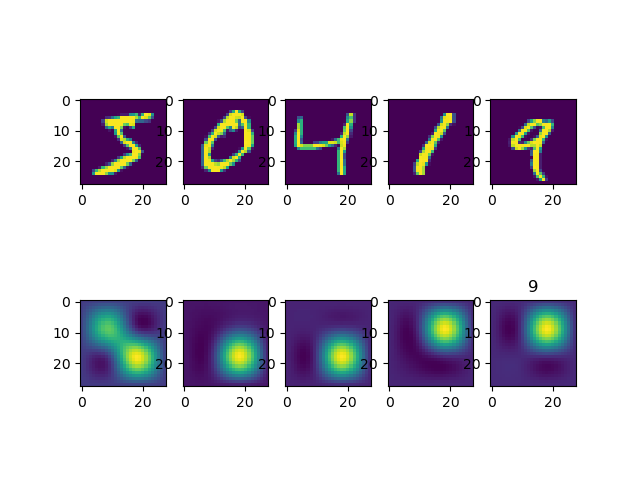

Try 0 Run the CNN over one image only
Net CNN_one_layer Epoch :  1 	 loss : 1.8768887090657975 accuracy : 44.877373
Net CNN_one_layer Epoch :  2 	 loss : 1.2393750170864044 accuracy : 45.27294
Net CNN_one_layer Epoch :  3 	 loss : 1.2640207069642304 accuracy : 46.281647
Net CNN_one_layer Epoch :  4 	 loss : 1.3325320281161748 accuracy : 47.092564
Try 0 Run the CNN over the stacked images
Net CNN Epoch :  1 	 loss : 0.2734843060649871 accuracy : 80.419304
Net CNN Epoch :  2 	 loss : 0.46132598869404345 accuracy : 83.18829
Net CNN Epoch :  3 	 loss : 0.4357064850786589 accuracy : 84.47389
Net CNN Epoch :  4 	 loss : 0.7915785289282901 accuracy : 84.61234
Try 0 Run the CNN+RNN over the stacked images
Net RNN_Net Epoch :  1 	 loss : 0.2967098150373701 accuracy : 83.04984
Net RNN_Net Epoch :  2 	 loss : 0.12449906328431008 accuracy : 86.412186
Net RNN_Net Epoch :  3 	 loss : 0.05232078012258805 accuracy : 87.91535
Net RNN_Net Epoch :  4 	 loss : 0.35915987351784534 accuracy : 88.548256


<IPython.core.display.Javascript object>


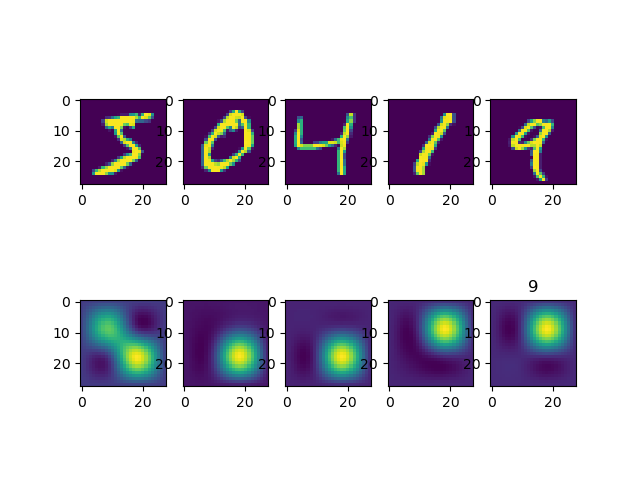

Try 1 Run the CNN over one image only
Net CNN_one_layer Epoch :  1 	 loss : 1.767838904673602 accuracy : 44.462025
Net CNN_one_layer Epoch :  2 	 loss : 1.1045730471190154 accuracy : 46.459652
Net CNN_one_layer Epoch :  3 	 loss : 1.5886793294137773 accuracy : 45.43117
Net CNN_one_layer Epoch :  4 	 loss : 2.0783344972848092 accuracy : 46.815666
Try 1 Run the CNN over the stacked images
Net CNN Epoch :  1 	 loss : 0.5005617459160647 accuracy : 81.07199
Net CNN Epoch :  2 	 loss : 0.7406150602266179 accuracy : 83.06962
Net CNN Epoch :  3 	 loss : 0.23217858874905425 accuracy : 84.05855
Net CNN Epoch :  4 	 loss : 0.4901843194499289 accuracy : 84.889244
Try 1 Run the CNN+RNN over the stacked images
Net RNN_Net Epoch :  1 	 loss : 0.48597427279941974 accuracy : 82.120255
Net RNN_Net Epoch :  2 	 loss : 1.2571664457177354 accuracy : 85.30459
Net RNN_Net Epoch :  3 	 loss : 0.46732401563039655 accuracy : 87.06487
Net RNN_Net Epoch :  4 	 loss : 0.19860850581644995 accuracy : 87.40111


<IPython.core.display.Javascript object>


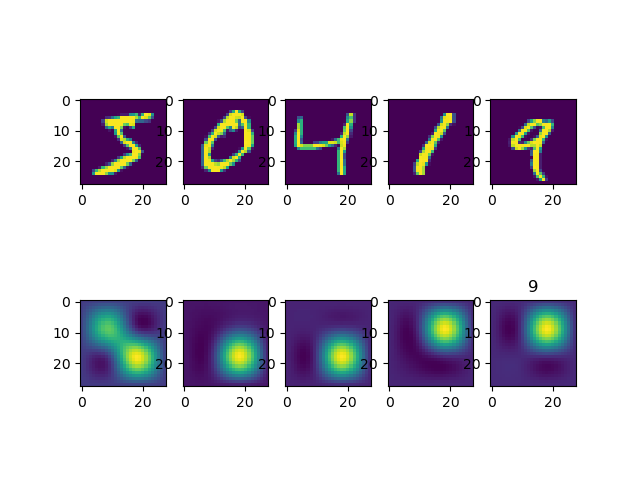

Try 2 Run the CNN over one image only
Net CNN_one_layer Epoch :  1 	 loss : 1.6180745419488451 accuracy : 44.738926
Net CNN_one_layer Epoch :  2 	 loss : 1.663837788325755 accuracy : 46.47943
Net CNN_one_layer Epoch :  3 	 loss : 1.2247788875781511 accuracy : 46.439873
Net CNN_one_layer Epoch :  4 	 loss : 2.0782710487961835 accuracy : 46.34098
Try 2 Run the CNN over the stacked images
Net CNN Epoch :  1 	 loss : 0.09347987610083414 accuracy : 81.230225
Net CNN Epoch :  2 	 loss : 0.13932884920641572 accuracy : 83.504745
Net CNN Epoch :  3 	 loss : 0.31886119106466004 accuracy : 83.80142
Net CNN Epoch :  4 	 loss : 0.7044616515795379 accuracy : 84.96835
Try 2 Run the CNN+RNN over the stacked images
Net RNN_Net Epoch :  1 	 loss : 0.7677313599893769 accuracy : 82.43671
Net RNN_Net Epoch :  2 	 loss : 0.6111535460449241 accuracy : 85.68038
Net RNN_Net Epoch :  3 	 loss : 0.5758898949656396 accuracy : 86.135284
Net RNN_Net Epoch :  4 	 loss : 0.3595591631807566 accuracy : 87.89557


<IPython.core.display.Javascript object>


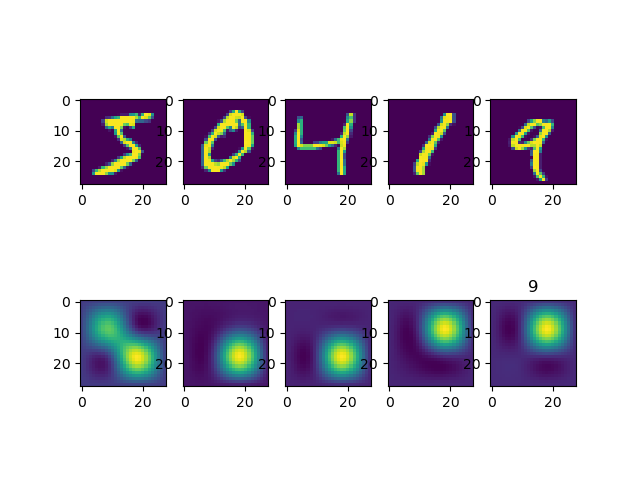

Try 3 Run the CNN over one image only
Net CNN_one_layer Epoch :  1 	 loss : 2.364604274787966 accuracy : 44.40269
Net CNN_one_layer Epoch :  2 	 loss : 1.4156293467229581 accuracy : 45.94541
Net CNN_one_layer Epoch :  3 	 loss : 1.6332808348286951 accuracy : 46.89478
Net CNN_one_layer Epoch :  4 	 loss : 1.7956819114301985 accuracy : 45.94541
Try 3 Run the CNN over the stacked images
Net CNN Epoch :  1 	 loss : 0.6849537740206918 accuracy : 82.93117
Net CNN Epoch :  2 	 loss : 0.654506486075189 accuracy : 85.36392
Net CNN Epoch :  3 	 loss : 0.5614002636678008 accuracy : 85.423256
Net CNN Epoch :  4 	 loss : 0.8173350453659285 accuracy : 86.669304
Try 3 Run the CNN+RNN over the stacked images
Net RNN_Net Epoch :  1 	 loss : 0.3887925910301822 accuracy : 86.2144
Net RNN_Net Epoch :  2 	 loss : 0.5686082268757184 accuracy : 88.15269
Net RNN_Net Epoch :  3 	 loss : 0.4909564385772333 accuracy : 88.370255
Net RNN_Net Epoch :  4 	 loss : 0.3193299771508152 accuracy : 89.29984


In [11]:
#Run with a constant trajectory  - test with a few trajectories to see is there is a change

cnn_one_image = []
cnn_lasagna = []
cnn_rnn = []
cnn_one_image_train_loss = []
cnn_lasagna_train_loss = []
cnn_rnn_train_loss = []
for i in range(4):
    #Load the training data
    train_dataloader, test_dataloader = create_dataset(images, labels,res = 6,mixed_state = False)
    print('Try {} Run the CNN over one image only'.format(i))
    cnn1_train_loss, cnn1_test_loss, cnn1_test_accur =  train(train_dataloader, test_dataloader,net = CNN_one_layer().double(), epochs = 4)
    cnn_one_image.append(cnn1_test_accur[-1])
    cnn_one_image_train_loss.append(cnn1_train_loss[-1])
    print('Try {} Run the CNN over the stacked images'.format(i))
    cnn_train_loss, cnn_test_loss, cnn_test_accur =  train(train_dataloader, test_dataloader,net = CNN().double(), epochs = 4)
    cnn_lasagna.append(cnn_test_accur[-1])
    cnn_lasagna_train_loss.append(cnn_train_loss[-1])
    print('Try {} Run the CNN+RNN over the stacked images'.format(i))
    rnn_train_loss, rnn_test_loss, rnn_test_accur =  train(train_dataloader, test_dataloader,net = RNN_Net().double(), epochs = 4)
    cnn_rnn.append(rnn_test_accur[-1])
    cnn_rnn_train_loss.append(rnn_train_loss[-1])